# Proyek Klasifikasi Gambar: Waste Classification
**Nama:**
- Falah Asyraf Darmawan Putra (203012420026)
- Akif Rachmat Hidayah (203012420037)

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library untuk Mengolah data seperti ekstrak dari zip
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import kagglehub

In [2]:
# Library Untuk Membangun Model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import time
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, DepthwiseConv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

## Data Preparation

### Data Loading

In [3]:
# Jika path merged tidak ada di os maka donwload dan pindahkan

if "trash-classification" not in os.listdir():
    path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")
    # Tentukan lokasi tujuan di Google Colab
    colab_path = "/content/trash-classification"

    # Pindahkan direktori dataset
    if colab_path not in os.listdir():
        shutil.move(path, colab_path)

    print(f"Dataset dipindahkan ke: {colab_path}")
else:
    colab_path = "trash-classification"
    print("Dataset sudah ada di os")

100%|██████████| 920M/920M [00:41<00:00, 23.5MB/s]

Extracting files...


Dataset dipindahkan ke: /content/trash-classification


In [4]:
data_path = os.path.join(colab_path, "images", "images")
data_name_list = os.listdir(data_path)
print(data_name_list)
print(data_path)

['coffee_grounds', 'plastic_trash_bags', 'plastic_food_containers', 'cardboard_packaging', 'styrofoam_food_containers', 'plastic_cup_lids', 'plastic_detergent_bottles', 'aluminum_soda_cans', 'cardboard_boxes', 'plastic_soda_bottles', 'magazines', 'plastic_shopping_bags', 'aluminum_food_cans', 'glass_cosmetic_containers', 'newspaper', 'plastic_water_bottles', 'steel_food_cans', 'disposable_plastic_cutlery', 'clothing', 'styrofoam_cups', 'shoes', 'aerosol_cans', 'office_paper', 'food_waste', 'paper_cups', 'glass_food_jars', 'glass_beverage_bottles', 'eggshells', 'plastic_straws', 'tea_bags']
/content/trash-classification/images/images


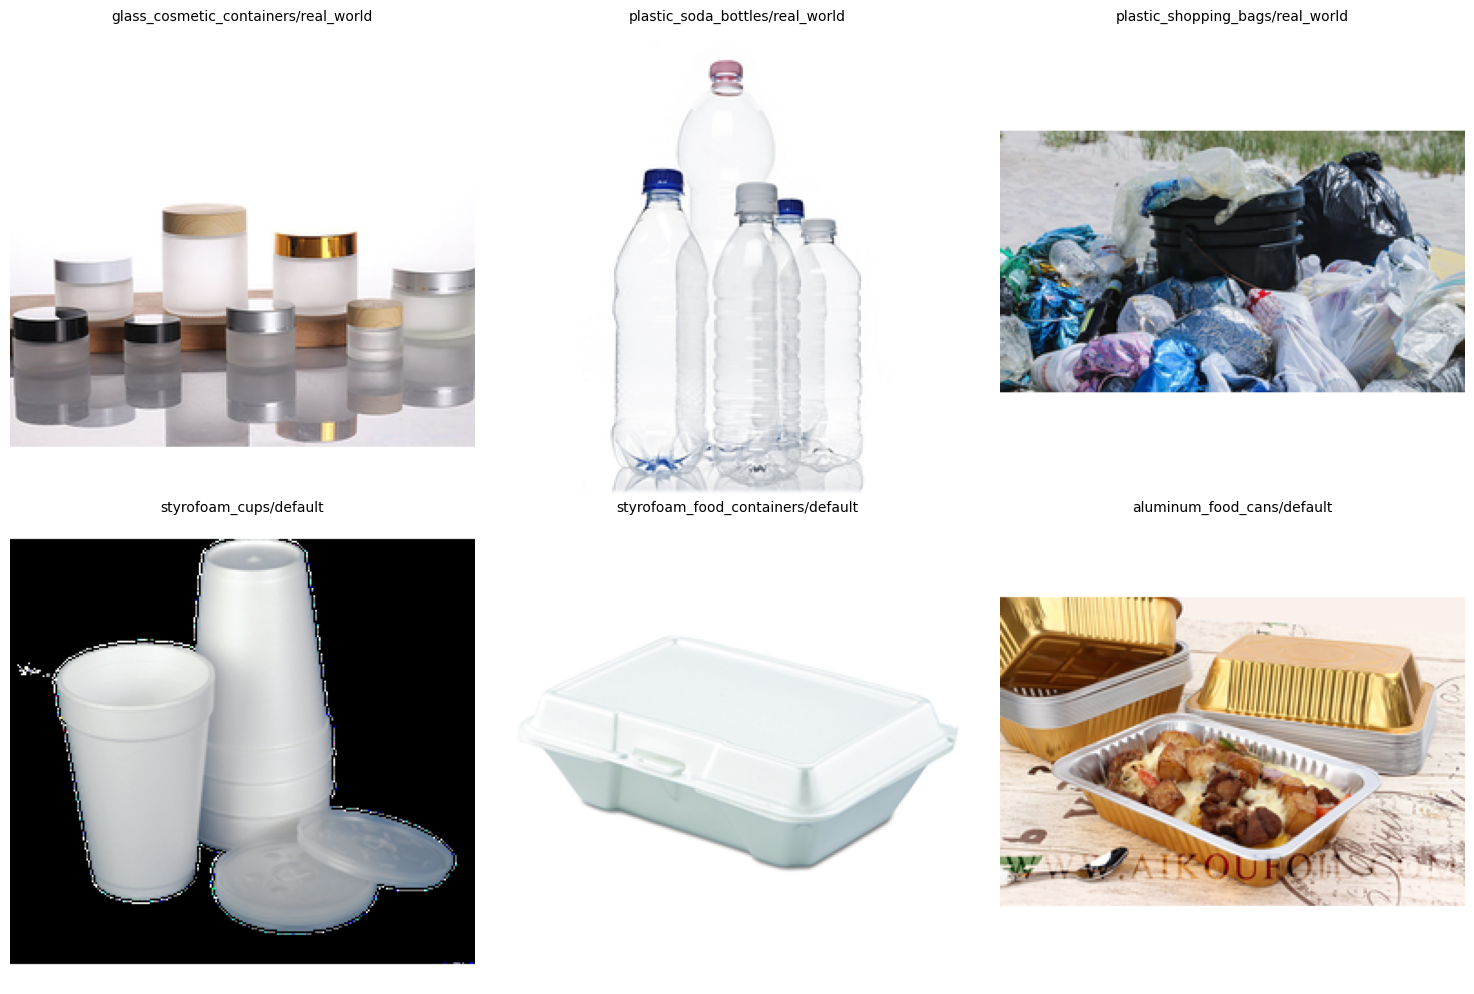

In [5]:
num_samples = 6  # Jumlah gambar yang ingin ditampilkan
all_images = []

# Kumpulkan semua gambar dari semua subfolder (default/ & real_world/)
temp_image_list = []
for dir_name in data_name_list:
    dir_path = os.path.join(data_path, dir_name)
    if not os.path.isdir(dir_path):  # Pastikan hanya mengambil folder
        continue
    for subfolder in os.listdir(dir_path):  # Cek kategori dalam folder (default/ & real_world/)
        subfolder_path = os.path.join(dir_path, subfolder)
        if os.path.isdir(subfolder_path):  # Hanya ambil folder
            for file in os.listdir(subfolder_path):
                if file.endswith(('.png', '.jpg', '.jpeg')):  # Pastikan hanya file gambar
                    temp_image_list.append((f"{dir_name}/{subfolder}", os.path.join(subfolder_path, file)))

# Pilih gambar secara acak
if temp_image_list:
    selected_images = random.sample(temp_image_list, min(num_samples, len(temp_image_list)))

    # Plot gambar
    fig, plotting = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Grid 2x3 untuk 6 gambar
    plotting = plotting.flatten()

    for idx, (dir_name, image_path) in enumerate(selected_images):
        image = plt.imread(image_path)
        plotting[idx].imshow(image)
        plotting[idx].set_title(f"{dir_name}", fontsize=10)
        plotting[idx].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada gambar yang ditemukan di dataset!")

### Data Preprocessing

#### Split Dataset

In [6]:
split_path = os.path.join("split_dataset")


In [7]:
# Buat direktori train, val, dan test
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(split_path, split), exist_ok=True)

# Proporsi split
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Iterasi setiap kategori sampah (Plastic water bottles, Plastic soda bottles, dll.)
for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)

    if not os.path.isdir(category_path):  # Skip jika bukan folder
        continue

    all_images = []  # List untuk menyimpan semua gambar dalam kategori ini

    # Ambil gambar dari subfolder "default" dan "real_world"
    for subfolder in ["default", "real_world"]:
        subfolder_path = os.path.join(category_path, subfolder)

        if os.path.isdir(subfolder_path):  # Pastikan folder ada
            images = [f for f in os.listdir(subfolder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            all_images.extend([os.path.join(subfolder_path, img) for img in images])  # Simpan full path

    random.shuffle(all_images)

    if len(all_images) < 3:  # Skip kategori dengan gambar terlalu sedikit
        print(f"Skipping {category}, not enough images to split.")
        continue

    # Split dataset
    train_images, temp_images = train_test_split(all_images, test_size=(val_ratio + test_ratio), random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Fungsi untuk memindahkan file
    def move_files(image_list, destination):
        dest_folder = os.path.join(split_path, destination, category)
        os.makedirs(dest_folder, exist_ok=True)
        for src in image_list:
            dst = os.path.join(dest_folder, os.path.basename(src))
            shutil.copy(src, dst)

    # Pindahkan gambar ke masing-masing folder
    move_files(train_images, "train")
    move_files(val_images, "val")
    move_files(test_images, "test")

print("Dataset berhasil di-split!")

Dataset berhasil di-split!


In [8]:
# Delete after succesfully split dataset
shutil.rmtree(colab_path)

In [9]:
for split in ["train", "val", "test"]:
    split_category_path = os.path.join(split_path, split) # Get the path to the current split
    for category in os.listdir(split_category_path): # List categories within the current split
        category_path = os.path.join(split_category_path, category) # Path to the specific category
        if os.path.isdir(category_path): # Check if the path is a directory
            print(f"{split} - {category}: {len(os.listdir(category_path))}") # List the contents if a directory

train - coffee_grounds: 239
train - plastic_trash_bags: 240
train - plastic_food_containers: 238
train - cardboard_packaging: 240
train - styrofoam_food_containers: 242
train - plastic_cup_lids: 242
train - plastic_detergent_bottles: 241
train - aluminum_soda_cans: 240
train - cardboard_boxes: 235
train - plastic_soda_bottles: 244
train - magazines: 239
train - plastic_shopping_bags: 240
train - aluminum_food_cans: 242
train - glass_cosmetic_containers: 241
train - newspaper: 235
train - plastic_water_bottles: 242
train - steel_food_cans: 238
train - disposable_plastic_cutlery: 240
train - clothing: 237
train - styrofoam_cups: 242
train - shoes: 237
train - aerosol_cans: 242
train - office_paper: 241
train - food_waste: 243
train - paper_cups: 240
train - glass_food_jars: 242
train - glass_beverage_bottles: 243
train - eggshells: 240
train - plastic_straws: 240
train - tea_bags: 240
val - coffee_grounds: 49
val - plastic_trash_bags: 47
val - plastic_food_containers: 50
val - cardboard_

##Preprocessing gambar

In [10]:
IMAGE_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    'split_dataset/train',  # ganti path sesuai milikmu
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    'split_dataset/val',  # ganti path sesuai milikmu
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7205 images belonging to 30 classes.
Found 1433 images belonging to 30 classes.


## Modelling

In [11]:
img_height = 224
img_width = 224

In [12]:
def build_mobilenetv2_finetuned(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Fine-tune 20 layer terakhir
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
    ModelCheckpoint('best_lightweight_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]


In [13]:
num_class=len(os.listdir(os.path.join(split_path, "train")))

In [15]:
model = build_mobilenetv2_finetuned(input_shape=(img_height, img_width, 3), num_classes=num_class)  # Sesuaikan ukuran input gambar
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,622,686 (10.00 MB)

 Trainable params: 1,570,782 (5.99 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [16]:
train_dir = 'split_dataset/train'  # Ganti sesuai path dataset
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
print(class_counts)

{'coffee_grounds': 239, 'plastic_trash_bags': 240, 'plastic_food_containers': 238, 'cardboard_packaging': 240, 'styrofoam_food_containers': 242, 'plastic_cup_lids': 242, 'plastic_detergent_bottles': 241, 'aluminum_soda_cans': 240, 'cardboard_boxes': 235, 'plastic_soda_bottles': 244, 'magazines': 239, 'plastic_shopping_bags': 240, 'aluminum_food_cans': 242, 'glass_cosmetic_containers': 241, 'newspaper': 235, 'plastic_water_bottles': 242, 'steel_food_cans': 238, 'disposable_plastic_cutlery': 240, 'clothing': 237, 'styrofoam_cups': 242, 'shoes': 237, 'aerosol_cans': 242, 'office_paper': 241, 'food_waste': 243, 'paper_cups': 240, 'glass_food_jars': 242, 'glass_beverage_bottles': 243, 'eggshells': 240, 'plastic_straws': 240, 'tea_bags': 240}


In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  # Sesuaikan jumlah epoch
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.1195 - loss: 3.2642
Epoch 1: val_loss improved from inf to 1.85787, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 130s 494ms/step - accuracy: 0.1199 - loss: 3.2625 - val_accuracy: 0.5290 - val_loss: 1.8579 - learning_rate: 1.0000e-04
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.4445 - loss: 1.9777
Epoch 2: val_loss improved from 1.85787 to 1.18903, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 98s 432ms/step - accuracy: 0.4446 - loss: 1.9772 - val_accuracy: 0.6650 - val_loss: 1.1890 - learning_rate: 1.0000e-04
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.5788 - loss: 1.4802
Epoch 3: val_loss improved from 1.18903 to 0.94000, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 95s 421ms/step - accuracy: 0.5789 - loss: 1.4798 - val_accuracy: 0.7202 - val_loss: 0.9400 - learning_rate: 1.0000e-04
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6548 - loss: 1.1709
Epoch 4: val_loss improved from 0.94000 to 0.82340, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 98s 431ms/step - accuracy: 0.6548 - loss: 1.1710 - val_accuracy: 0.7509 - val_loss: 0.8234 - learning_rate: 1.0000e-04
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.6893 - loss: 1.0468
Epoch 5: val_loss improved from 0.82340 to 0.78165, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 101s 445ms/step - accuracy: 0.6893 - loss: 1.0467 - val_accuracy: 0.7558 - val_loss: 0.7816 - learning_rate: 1.0000e-04
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.7300 - loss: 0.9108
Epoch 6: val_loss improved from 0.78165 to 0.72885, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 97s 431ms/step - accuracy: 0.7301 - loss: 0.9108 - val_accuracy: 0.7760 - val_loss: 0.7289 - learning_rate: 1.0000e-04
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7663 - loss: 0.7931
Epoch 7: val_loss did not improve from 0.72885
226/226 ━━━━━━━━━━━━━━━━━━━━ 144s 438ms/step - accuracy: 0.7663 - loss: 0.7931 - val_accuracy: 0.7830 - val_loss: 0.7327 - learning_rate: 1.0000e-04
Epoch 8/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7757 - loss: 0.7280
Epoch 8: val_loss improved from 0.72885 to 0.68343, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 142s 441ms/step - accuracy: 0.7757 - loss: 0.7280 - val_accuracy: 0.7983 - val_loss: 0.6834 - learning_rate: 1.0000e-04
Epoch 9/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8087 - loss: 0.6417
Epoch 9: val_loss did not improve from 0.68343
226/226 ━━━━━━━━━━━━━━━━━━━━ 99s 439ms/step - accuracy: 0.8086 - loss: 0.6418 - val_accuracy: 0.7934 - val_loss: 0.7072 - learning_rate: 1.0000e-04
Epoch 10/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8248 - loss: 0.5973
Epoch 10: val_loss improved from 0.68343 to 0.67595, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 98s 434ms/step - accuracy: 0.8248 - loss: 0.5973 - val_accuracy: 0.7983 - val_loss: 0.6760 - learning_rate: 1.0000e-04
Epoch 11/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8292 - loss: 0.5568
Epoch 11: val_loss improved from 0.67595 to 0.64519, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 98s 433ms/step - accuracy: 0.8292 - loss: 0.5567 - val_accuracy: 0.8109 - val_loss: 0.6452 - learning_rate: 1.0000e-04
Epoch 12/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8416 - loss: 0.5099
Epoch 12: val_loss improved from 0.64519 to 0.62881, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 98s 434ms/step - accuracy: 0.8416 - loss: 0.5099 - val_accuracy: 0.8221 - val_loss: 0.6288 - learning_rate: 1.0000e-04
Epoch 13/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8590 - loss: 0.4418
Epoch 13: val_loss did not improve from 0.62881
226/226 ━━━━━━━━━━━━━━━━━━━━ 101s 446ms/step - accuracy: 0.8589 - loss: 0.4418 - val_accuracy: 0.8053 - val_loss: 0.6964 - learning_rate: 1.0000e-04
Epoch 14/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8543 - loss: 0.4403
Epoch 14: val_loss did not improve from 0.62881
226/226 ━━━━━━━━━━━━━━━━━━━━ 100s 440ms/step - accuracy: 0.8543 - loss: 0.4403 - val_accuracy: 0.8144 - val_loss: 0.6810 - learning_rate: 1.0000e-04
Epoch 15/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8827 - loss: 0.3732
Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 15: val_loss did not improve from 0.62881
226/226 ━━━━━━━━━━━━━━━━━━━━ 100s 442ms/step - accuracy: 0.8827 -

226/226 ━━━━━━━━━━━━━━━━━━━━ 97s 430ms/step - accuracy: 0.8825 - loss: 0.3563 - val_accuracy: 0.8255 - val_loss: 0.6126 - learning_rate: 1.0000e-05
Epoch 17/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8934 - loss: 0.3267
Epoch 17: val_loss improved from 0.61261 to 0.59312, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 100s 440ms/step - accuracy: 0.8934 - loss: 0.3268 - val_accuracy: 0.8360 - val_loss: 0.5931 - learning_rate: 1.0000e-05
Epoch 18/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8893 - loss: 0.3399
Epoch 18: val_loss improved from 0.59312 to 0.59117, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 98s 432ms/step - accuracy: 0.8893 - loss: 0.3398 - val_accuracy: 0.8388 - val_loss: 0.5912 - learning_rate: 1.0000e-05
Epoch 19/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9005 - loss: 0.3039
Epoch 19: val_loss improved from 0.59117 to 0.58479, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 98s 433ms/step - accuracy: 0.9005 - loss: 0.3039 - val_accuracy: 0.8388 - val_loss: 0.5848 - learning_rate: 1.0000e-05
Epoch 20/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9001 - loss: 0.3095
Epoch 20: val_loss improved from 0.58479 to 0.58136, saving model to best_lightweight_model.h5


226/226 ━━━━━━━━━━━━━━━━━━━━ 98s 434ms/step - accuracy: 0.9001 - loss: 0.3095 - val_accuracy: 0.8388 - val_loss: 0.5814 - learning_rate: 1.0000e-05
Epoch 21/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8933 - loss: 0.3106
Epoch 21: val_loss did not improve from 0.58136
226/226 ━━━━━━━━━━━━━━━━━━━━ 96s 423ms/step - accuracy: 0.8933 - loss: 0.3105 - val_accuracy: 0.8388 - val_loss: 0.5852 - learning_rate: 1.0000e-05
Epoch 22/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9023 - loss: 0.2881
Epoch 22: val_loss did not improve from 0.58136
226/226 ━━━━━━━━━━━━━━━━━━━━ 98s 431ms/step - accuracy: 0.9023 - loss: 0.2882 - val_accuracy: 0.8409 - val_loss: 0.5826 - learning_rate: 1.0000e-05
Epoch 23/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8986 - loss: 0.2899
Epoch 23: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 23: val_loss did not improve from 0.58136
226/226 ━━━━━━━━━━━━━━━━━━━━ 101s 445ms/step - accuracy: 0.8986 - l

## Evaluasi dan Visualisasi

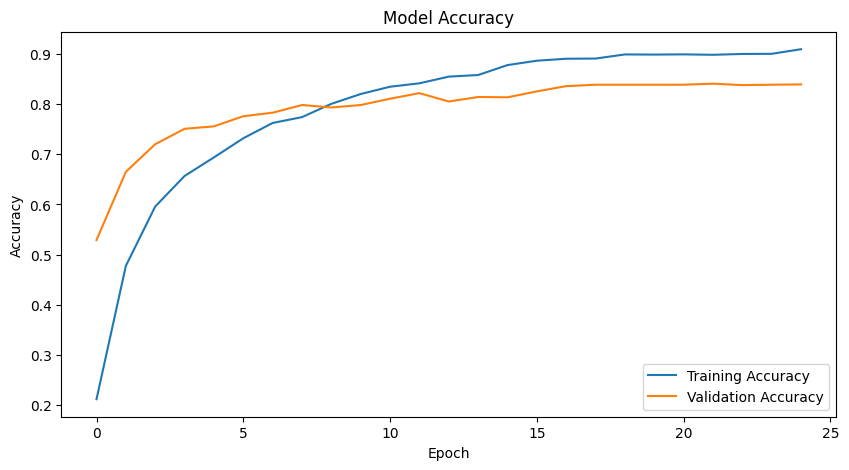

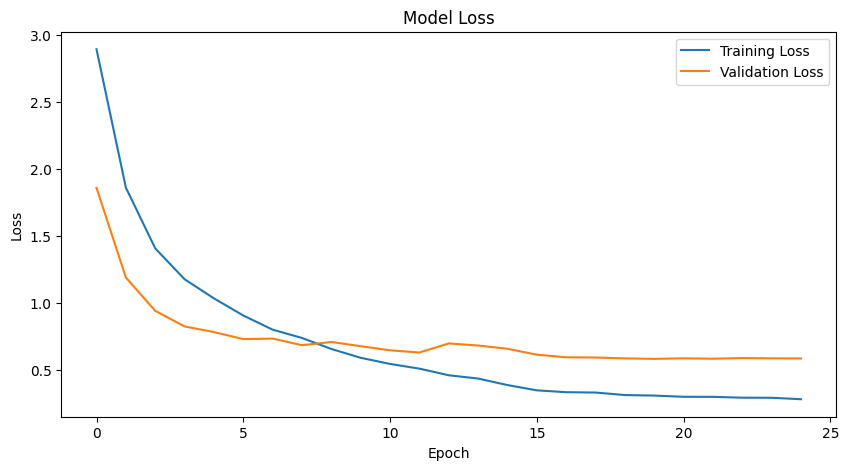

In [18]:


import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


Found 1423 images belonging to 30 classes.
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.8082 - loss: 0.6568
Test Loss: 0.6108
Test Accuracy: 0.8454
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step


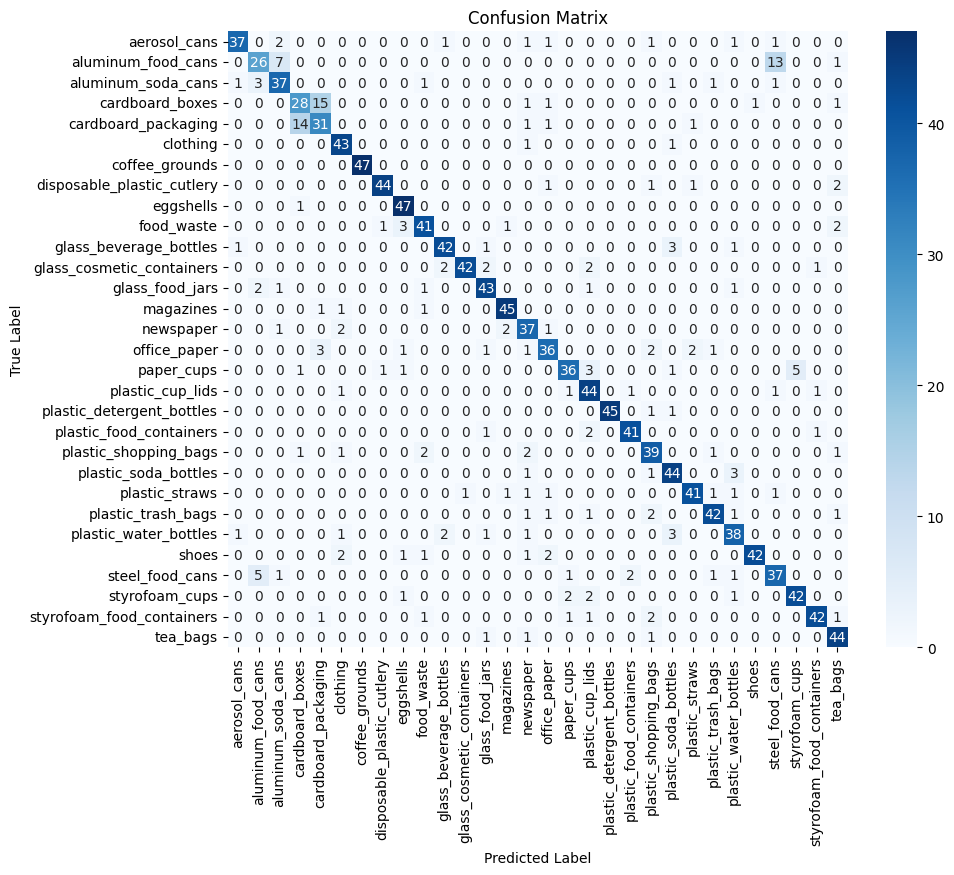

                            precision    recall  f1-score   support

              aerosol_cans       0.93      0.82      0.87        45
        aluminum_food_cans       0.72      0.55      0.63        47
        aluminum_soda_cans       0.76      0.82      0.79        45
           cardboard_boxes       0.62      0.60      0.61        47
       cardboard_packaging       0.61      0.65      0.63        48
                  clothing       0.84      0.96      0.90        45
            coffee_grounds       1.00      1.00      1.00        47
disposable_plastic_cutlery       0.96      0.90      0.93        49
                 eggshells       0.87      0.98      0.92        48
                food_waste       0.85      0.85      0.85        48
    glass_beverage_bottles       0.89      0.88      0.88        48
 glass_cosmetic_containers       0.98      0.86      0.91        49
           glass_food_jars       0.86      0.88      0.87        49
                 magazines       0.92      0.94

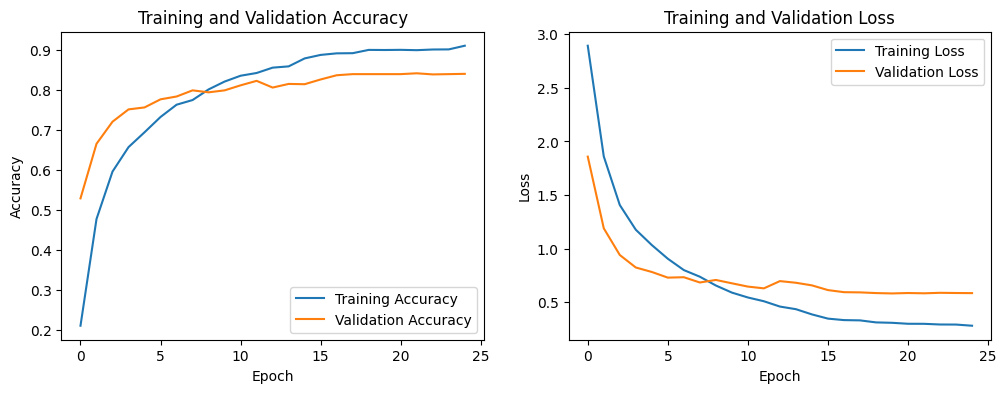

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load the best model
model.load_weights('best_lightweight_model.h5')

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_dataset/test',
    target_size=(img_height, img_width),
    batch_size=32,
    shuffle=False,  # Important for correct confusion matrix
    class_mode='categorical'
)

loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict the labels for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


## Konversi Model

In [20]:
# prompt: convert model into TFLite and TFJS

import tensorflow as tf

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpd9yq1p8d'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  132126256762128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124361995856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124361996240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126256761552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126256762320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132126256761936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124361995472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124361997392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124361993744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124361993360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1321243619943

## Inference (Optional)

In [21]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference for TFLite
start_time = time.time()
interpreter.invoke()
end_time = time.time()
tflite_inference_time = end_time - start_time
print(f"TFLite inference time: {tflite_inference_time:.6f} seconds")


TFLite inference time: 0.009102 seconds


In [22]:
# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Cek input dan output model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Details:", input_details)
print("Output Details:", output_details)

Input Details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 178, 'shape': array([ 1, 30], dtype=int32), 'shape_signature': array([-1, 30], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [34]:
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import os

# Pastikan lokasi file benar
img_path = "Image_i001.jpg"

# Cek apakah file ada
if not os.path.exists(img_path):
    raise FileNotFoundError(f"File {img_path} tidak ditemukan!")

# Load gambar dengan PIL jika OpenCV gagal
img = cv2.imread(img_path)
if img is None:
    print("⚠️ OpenCV gagal membaca gambar, coba pakai PIL...")
    img = Image.open(img_path).convert("RGB")  # Pastikan dalam format RGB
    img = np.array(img)  # Ubah ke array numpy

# Resize dan preprocessing
img = cv2.resize(img, (224, 224))
img = img.astype(np.float32) / 255.0  # Normalisasi
img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Ambil input dan output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Masukkan gambar ke model
interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()  # Jalankan model

# Ambil hasil prediksi
output = interpreter.get_tensor(output_details[0]['index'])
print("✅ Output Model:", output)


✅ Output Model: [[1.16000185e-04 3.51075947e-01 5.55590901e-04 7.46852820e-05
  3.05203837e-04 1.07131955e-05 3.18938110e-05 9.52117534e-06
  4.70656778e-06 1.45096437e-05 1.61492990e-05 2.44686707e-05
  6.73348986e-05 3.63492882e-06 5.12118451e-04 7.97797838e-06
  8.10361016e-05 3.47988709e-04 1.05029733e-06 3.37075289e-05
  3.61156685e-06 5.57416788e-05 7.01071895e-06 5.70631819e-05
  1.69528241e-04 5.12762062e-06 6.46290660e-01 2.39443343e-05
  1.31430570e-05 7.98547262e-05]]


In [35]:
# Daftar kelas sesuai dataset yang kamu pakai
class_labels = [
    "aerosol_cans", "aluminum_food_cans", "aluminum_soda_cans",
    "cardboard_boxes", "cardboard_packaging", "clothing",
    "coffee_grounds", "disposable_plastic_cutlery", "eggshells",
    "food_waste", "glass_beverage_bottles", "glass_cosmetic_containers",
    "glass_food_jars", "magazines", "newspaper", "office_paper",
    "paper_cups", "plastic_cup_lids", "plastic_detergent_bottles",
    "plastic_food_containers", "plastic_shopping_bags", "plastic_soda_bottles",
    "plastic_straws", "plastic_trash_bags", "plastic_water_bottles",
    "shoes", "steel_food_cans", "styrofoam_cups",
    "styrofoam_food_containers", "tea_bags"
]
# Ambil indeks dengan probabilitas tertinggi
predicted_index = np.argmax(output)
predicted_class = class_labels[predicted_index]
predicted_confidence = output[0][predicted_index] * 100  # Ubah ke persen

print(f"📌 Prediksi Model: {predicted_class} ({predicted_confidence:.2f}%)")


📌 Prediksi Model: steel_food_cans (64.63%)


# 🧠 Kesimpulan
Model telah menunjukkan performa yang baik dalam mengklasifikasikan berbagai jenis sampah ke dalam 30 kategori yang tersedia.

Namun, masih terdapat tantangan pada klasifikasi sampah berbahan aluminium, seperti aluminum food cans dan aluminum soda cans. Model cenderung mengelompokkannya ke dalam kategori steel food cans, yang kemungkinan besar disebabkan oleh kemiripan visual antar material tersebut.

Hal ini menunjukkan perlunya peningkatan pada fitur pembeda antara objek yang memiliki tampilan serupa namun berasal dari material yang berbeda.